In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [2]:
import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent))

In [3]:
from decoding.beliefPropagation import performBeliefPropagationFast
from decoding.OSD import performOSD

In [4]:
codes = [
    "[[72, 12, 6]]",
    "[[90, 8, 10]]",
    "[[108, 8, 10]]",
    "[[144, 12, 12]]",
    "[[288, 12, 18]]",
]

trials = 10000
physicalErrorRates = np.logspace(-3.2, -1.3, 8)
results_BP = {}

In [5]:
np.random.seed(0)

In [6]:
for code in tqdm.tqdm(codes):
    oc = np.load(f'../codes/{code}.npz')
    name = code
    results_BP[name] = {}
    code = oc['Hx']
    Lx = oc['Lx']
    distance = oc['distance']
    n = len(code[0])
    logicalErrorRates = []
    BPs_fault_rates = []
    BPs_miscorrected_rates = []
    incorrectable_rates = []
    degeneracies = []
    
    for errorRate in physicalErrorRates:
        
        initialBeliefs = [np.log((1 - errorRate) / errorRate)] * n
        logical_error = 0
        BPs_fault = 0
        BPs_miscorrected = 0
        incorrectable = 0
        degenerateErrors = 0
        
        
        for _ in range(trials):
            
            #### CODE CAPACITY ERROR MODEL ####
            # non-trivial pythonic way to generate random bitstring with given error rate
            error = (np.random.random(n) < errorRate).astype(int)
            
            syndrome = (error @ code.T) % 2
            
            #### SIMPLE PHENOMENOLOGICAL ERROR MODEL ####
            # measurementError = (np.random.random(len(syndrome)) < errorRate).astype(int)
            # syndrome = (syndrome + measurementError) % 2
            
            detection, isSyndromeFound, llrs = performBeliefPropagationFast(code, syndrome, initialBeliefs, verbose=False)
            
            if not isSyndromeFound:
                logical_error += 1
                BPs_fault += 1
                
                # detection = performOSD(code, syndrome, llrs, detection)
                
                

            # This is the XOR, between the actual error and the detected error. We are simulating the correction of the error
            residual = (detection + error) % 2
            
            syndromeLogic = (Lx @ residual) % 2
            
            if isSyndromeFound and not np.any(syndromeLogic) and (np.array_equal(detection, error) == False):
                degenerateErrors += 1
            
            if np.any(syndromeLogic):
                logical_error += 1

                error_weight = np.sum(error)
                if error_weight < (distance // 2):
                    BPs_miscorrected += 1
                else:
                    incorrectable += 1
                                    
        
        ler = logical_error / trials
        logicalErrorRates.append(ler)
        BPs_fault_rates.append(BPs_fault)
        BPs_miscorrected_rates.append(BPs_miscorrected)
        incorrectable_rates.append(incorrectable)
        degeneracies.append(degenerateErrors)
        
    results_BP[name]['ler'] = logicalErrorRates
    results_BP[name]['BPs_fault'] = BPs_fault_rates
    results_BP[name]['BPs_miscorrected'] = BPs_miscorrected_rates
    results_BP[name]['incorrectable'] = incorrectable_rates
    results_BP[name]['degeneracies'] = degeneracies

    
# save results under /notebooks/data/BP.npz
np.savez('data/BP.npz', results=results_BP)



  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [21:46<00:00, 261.36s/it]


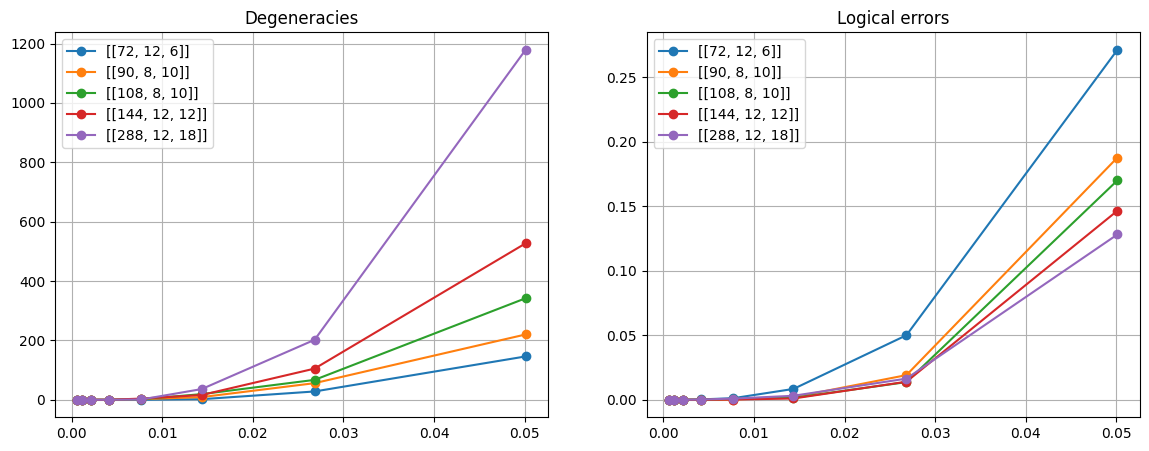

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for name in results_BP:
    axes[0].plot(physicalErrorRates, results_BP[name]['degeneracies'], label=name, marker='o')
    axes[0].grid(True)
    axes[0].legend()
    axes[0].set_title('Degeneracies')
    
for name in results_BP:
    axes[1].plot(physicalErrorRates, results_BP[name]['ler'], label=name, marker='o')
    axes[1].grid(True)
    axes[1].legend()
    axes[1].set_title('Logical errors')

In [8]:
names = codes  # preserve the original order used to build `results`
code_labels = ['72', '90', '108', '144', '288']  # n values for labeling
x = np.arange(len(physicalErrorRates))
n_codes = len(names)
bar_width = 0.12  # narrower bars
group_spacing = 0.15  # space between groups

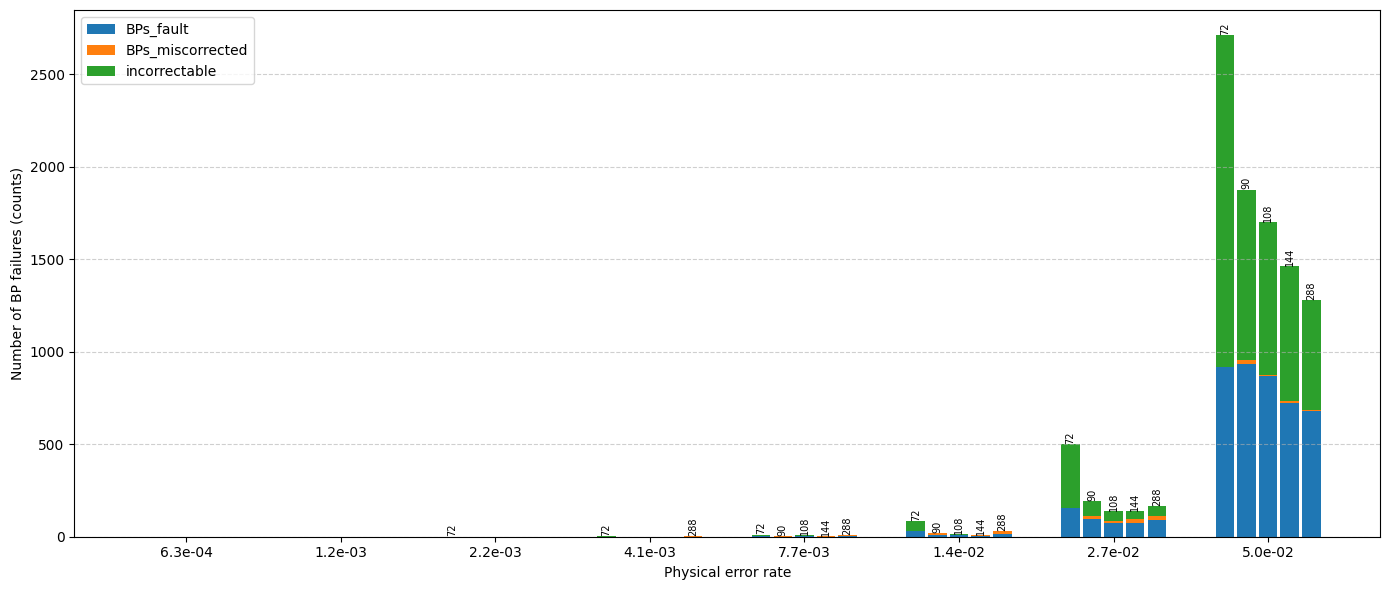

In [9]:
plt.figure(figsize=(14, 6))
for i, name in enumerate(names):
    bps_fault = np.array(results_BP[name]['BPs_fault'])
    bps_misc = np.array(results_BP[name]['BPs_miscorrected'])
    incorrect = np.array(results_BP[name]['incorrectable'])
    positions = x + i * (bar_width + 0.02)  # add small gap between bars

    if i == 0:
        plt.bar(positions, bps_fault, bar_width, label='BPs_fault', color='tab:blue')
        plt.bar(positions, bps_misc, bar_width, bottom=bps_fault, label='BPs_miscorrected', color='tab:orange')
        plt.bar(positions, incorrect, bar_width, bottom=bps_fault + bps_misc, label='incorrectable', color='tab:green')
    else:
        plt.bar(positions, bps_fault, bar_width, color='tab:blue')
        plt.bar(positions, bps_misc, bar_width, bottom=bps_fault, color='tab:orange')
        plt.bar(positions, incorrect, bar_width, bottom=bps_fault + bps_misc, color='tab:green')

# Add code labels (n values) on top of each bar group
for i, name in enumerate(names):
    bps_fault = np.array(results_BP[name]['BPs_fault'])
    bps_misc = np.array(results_BP[name]['BPs_miscorrected'])
    incorrect = np.array(results_BP[name]['incorrectable'])
    total_height = bps_fault + bps_misc + incorrect
    positions = x + i * (bar_width + 0.02)
    
    for j, (pos, height) in enumerate(zip(positions, total_height)):
        if height > 0:  # only label bars with data
            plt.text(pos, height + 0.3, code_labels[i], ha='center', va='bottom', fontsize=7, rotation=90)

# center x-ticks under each group and format ticks
plt.xticks(x + (n_codes - 1) * (bar_width + 0.02) / 2, [f'{r:.1e}' for r in physicalErrorRates])
plt.xlabel('Physical error rate')
plt.ylabel('Number of BP failures (counts)')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [10]:
results_OSD = {}

for code in tqdm.tqdm(codes):
    oc = np.load(f'../codes/{code}.npz')
    name = code
    results_OSD[name] = {}
    code = oc['Hx']
    Lx = oc['Lx']
    distance = oc['distance']
    n = len(code[0])
    logicalErrorRates = []
    BPs_fault_rates = []
    BPs_miscorrected_rates = []
    incorrectable_rates = []
    degeneracies = []
    
    for errorRate in physicalErrorRates:
        
        initialBeliefs = [np.log((1 - errorRate) / errorRate)] * n
        logical_error = 0
        BPs_fault = 0
        BPs_miscorrected = 0
        incorrectable = 0
        degenerateErrors = 0
        
        
        for _ in range(trials):
            
            #### CODE CAPACITY ERROR MODEL ####
            # non-trivial pythonic way to generate random bitstring with given error rate
            error = (np.random.random(n) < errorRate).astype(int)
            
            syndrome = (error @ code.T) % 2
            
            #### SIMPLE PHENOMENOLOGICAL ERROR MODEL ####
            # measurementError = (np.random.random(len(syndrome)) < errorRate).astype(int)
            # syndrome = (syndrome + measurementError) % 2
            
            detection, isSyndromeFound, llrs = performBeliefPropagationFast(code, syndrome, initialBeliefs, verbose=False)
            
            if not isSyndromeFound:
                # logical_error += 1
                # BPs_fault += 1
                
                detection = performOSD(code, syndrome, llrs, detection)
                
                

            # This is the XOR, between the actual error and the detected error. We are simulating the correction of the error
            residual = (detection + error) % 2
            
            syndromeLogic = (Lx @ residual) % 2
            
            osd_syndrome_check = (detection @ code.T) % 2
            is_valid_osd = np.array_equal(osd_syndrome_check, syndrome)
            
            if is_valid_osd and not np.any(syndromeLogic) and (np.array_equal(detection, error) == False):
                degenerateErrors += 1
            
            if np.any(syndromeLogic):
                logical_error += 1

                error_weight = np.sum(error)
                if error_weight < (distance // 2):
                    BPs_miscorrected += 1
                else:
                    incorrectable += 1
                                    
        
        ler = logical_error / trials
        logicalErrorRates.append(ler)
        BPs_fault_rates.append(BPs_fault)
        BPs_miscorrected_rates.append(BPs_miscorrected)
        incorrectable_rates.append(incorrectable)
        degeneracies.append(degenerateErrors)
        
    results_OSD[name]['ler'] = logicalErrorRates
    results_OSD[name]['BPs_fault'] = BPs_fault_rates
    results_OSD[name]['BPs_miscorrected'] = BPs_miscorrected_rates
    results_OSD[name]['incorrectable'] = incorrectable_rates
    results_OSD[name]['degeneracies'] = degeneracies
    
np.savez('data/BPOSD.npz', results=results_OSD)

100%|██████████| 5/5 [1:56:26<00:00, 1397.21s/it]  


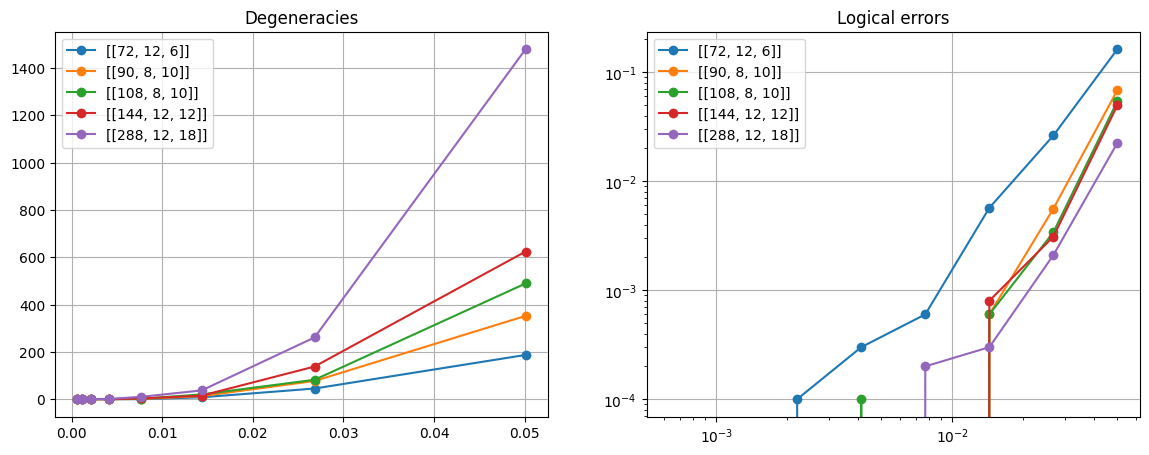

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for name in results_OSD:
    axes[0].plot(physicalErrorRates, results_OSD[name]['degeneracies'], label=name, marker='o')
    axes[0].grid(True)
    axes[0].legend()
    axes[0].set_title('Degeneracies')
    
for name in results_OSD:
    axes[1].plot(physicalErrorRates, results_OSD[name]['ler'], label=name, marker='o')
    axes[1].grid(True)
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_xscale('log')
    axes[1].set_title('Logical errors')

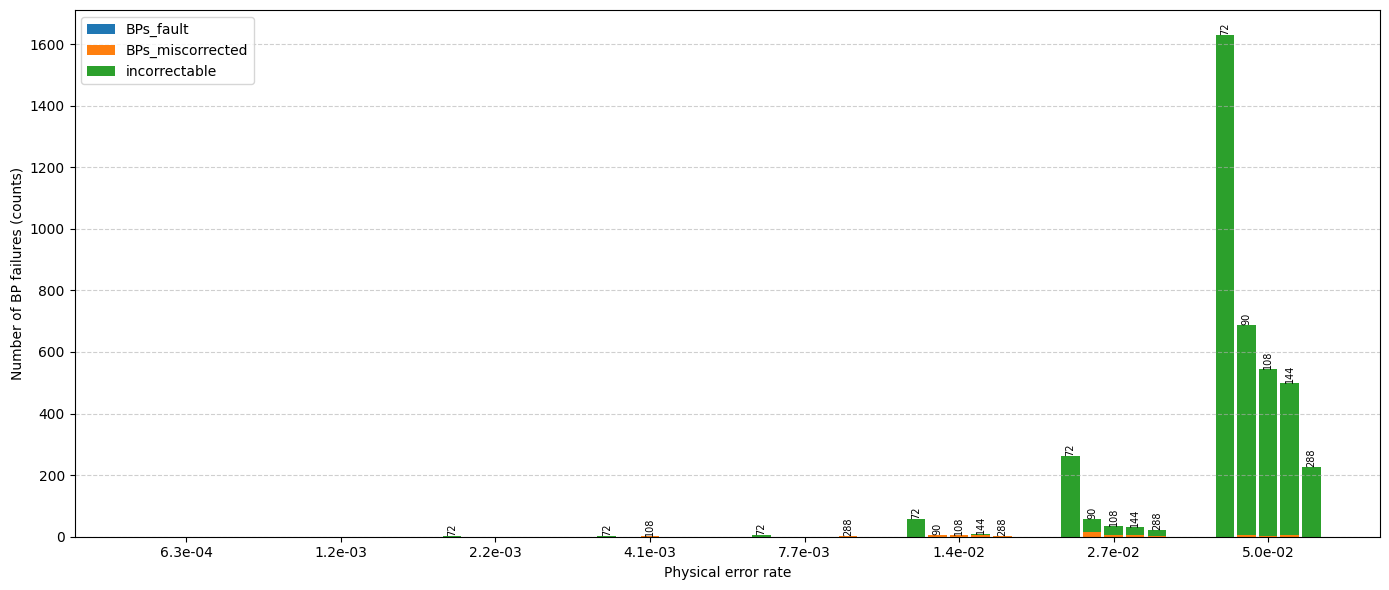

In [12]:
plt.figure(figsize=(14, 6))
for i, name in enumerate(names):
    bps_fault = np.array(results_OSD[name]['BPs_fault'])
    bps_misc = np.array(results_OSD[name]['BPs_miscorrected'])
    incorrect = np.array(results_OSD[name]['incorrectable'])
    positions = x + i * (bar_width + 0.02)  # add small gap between bars

    if i == 0:
        plt.bar(positions, bps_fault, bar_width, label='BPs_fault', color='tab:blue')
        plt.bar(positions, bps_misc, bar_width, bottom=bps_fault, label='BPs_miscorrected', color='tab:orange')
        plt.bar(positions, incorrect, bar_width, bottom=bps_fault + bps_misc, label='incorrectable', color='tab:green')
    else:
        plt.bar(positions, bps_fault, bar_width, color='tab:blue')
        plt.bar(positions, bps_misc, bar_width, bottom=bps_fault, color='tab:orange')
        plt.bar(positions, incorrect, bar_width, bottom=bps_fault + bps_misc, color='tab:green')

# Add code labels (n values) on top of each bar group
for i, name in enumerate(names):
    bps_fault = np.array(results_OSD[name]['BPs_fault'])
    bps_misc = np.array(results_OSD[name]['BPs_miscorrected'])
    incorrect = np.array(results_OSD[name]['incorrectable'])
    total_height = bps_fault + bps_misc + incorrect
    positions = x + i * (bar_width + 0.02)
    
    for j, (pos, height) in enumerate(zip(positions, total_height)):
        if height > 0:  # only label bars with data
            plt.text(pos, height + 0.3, code_labels[i], ha='center', va='bottom', fontsize=7, rotation=90)

# center x-ticks under each group and format ticks
plt.xticks(x + (n_codes - 1) * (bar_width + 0.02) / 2, [f'{r:.1e}' for r in physicalErrorRates])
plt.xlabel('Physical error rate')
plt.ylabel('Number of BP failures (counts)')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

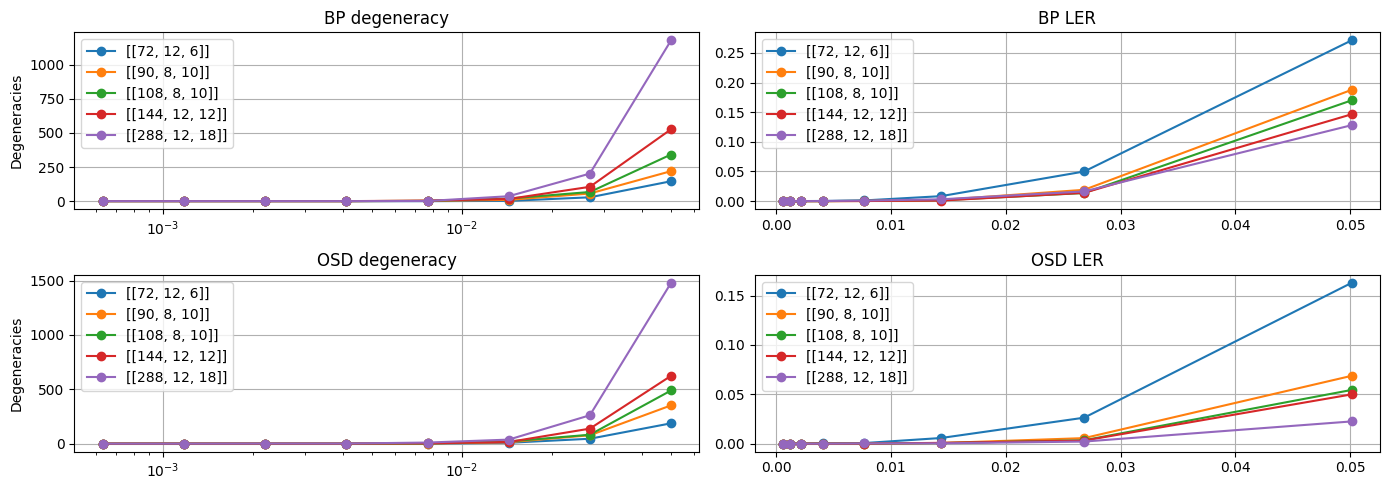

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 5))

# Left plot: BP results
for name in results_BP:
    axes[0][0].plot(physicalErrorRates, results_BP[name]['degeneracies'], label=name, marker='o')
axes[0][0].grid(True)
axes[0][0].legend()
# axes[0][0].set_xlabel('Physical error rate')
axes[0][0].set_xscale('log')
axes[0][0].set_ylabel('Degeneracies')
axes[0][0].set_title('BP degeneracy')

# Right plot: OSD results
for name in results_OSD:
    axes[1][0].plot(physicalErrorRates, results_OSD[name]['degeneracies'], label=name, marker='o')
axes[1][0].grid(True)
axes[1][0].legend()
# axes[1][0].set_xlabel('Physical error rate')
axes[1][0].set_xscale('log')
axes[1][0].set_ylabel('Degeneracies')
axes[1][0].set_title('OSD degeneracy')

for name in results_BP:
    axes[0][1].plot(physicalErrorRates, results_BP[name]["ler"], label=name, marker="o")
axes[0][1].grid(True)
axes[0][1].set_title("BP LER")
axes[0][1].legend()

for name in results_OSD:
    axes[1][1].plot(physicalErrorRates, results_OSD[name]['ler'], label=name, marker="o")
axes[1][1].grid(True)
axes[1][1].set_title("OSD LER")
axes[1][1].legend()

plt.tight_layout()
plt.show()

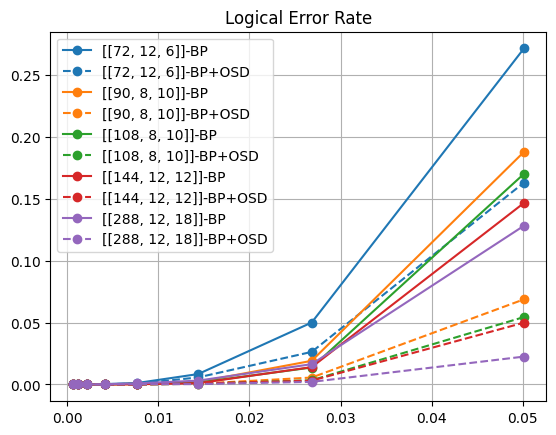

In [14]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, name in enumerate(results_BP):
    c = colors[i % len(colors)]
    plt.plot(physicalErrorRates, results_BP[name]['ler'], label=f"{name}-BP", marker='o', color=c)
    plt.plot(physicalErrorRates, results_OSD[name]['ler'], label=f"{name}-BP+OSD", marker='o', linestyle='dashed', color=c)
plt.legend()
plt.grid(True)
plt.title("Logical Error Rate")
plt.show()

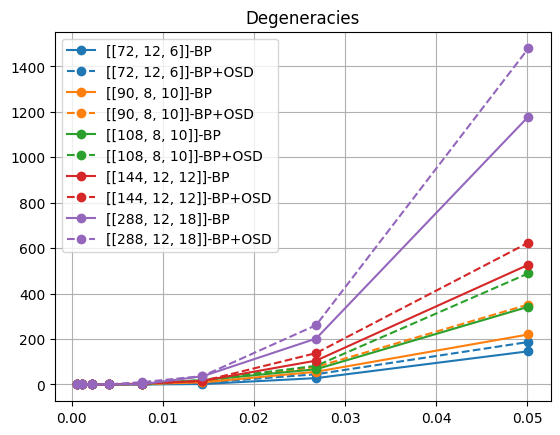

In [15]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, name in enumerate(results_BP):
    c = colors[i % len(colors)]
    plt.plot(physicalErrorRates, results_BP[name]['degeneracies'], label=f"{name}-BP", marker='o', color=c)
    plt.plot(physicalErrorRates, results_OSD[name]['degeneracies'], label=f"{name}-BP+OSD", marker='o', linestyle='dashed', color=c)
plt.legend()
plt.grid(True)
plt.title("Degeneracies")
plt.show()